<a href="https://colab.research.google.com/github/YasminaNasser/Oral-Diseases-Classification/blob/main/Teeth_Classification_cellula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np


In [ ]:
zip_path = "/content/drive/MyDrive/Cellula internship/Teeth project/Teeth DataSet.zip"
extract_to = "/content/extracted/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")


Extraction complete.


In [ ]:
train_dir = os.path.join(extract_to, "Teeth_Dataset/Training")
val_dir = os.path.join(extract_to, "Teeth_Dataset/Validation")
test_dir = os.path.join(extract_to, "Teeth_Dataset/Testing")

/tmp/ipython-input-27-68284503.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_values, palette='viridis')


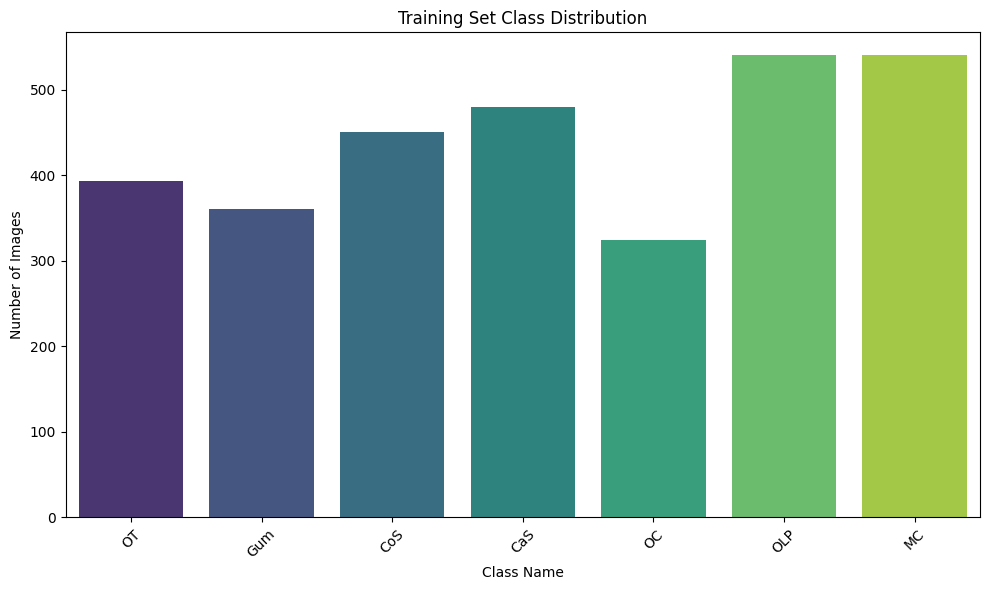

In [ ]:
classes = os.listdir(train_dir)
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
class_names = list(class_counts.keys())
class_values = list(class_counts.values())
plt.figure(figsize=(10,6))
sns.barplot(x=class_names, y=class_values, palette='viridis')
plt.title("Training Set Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

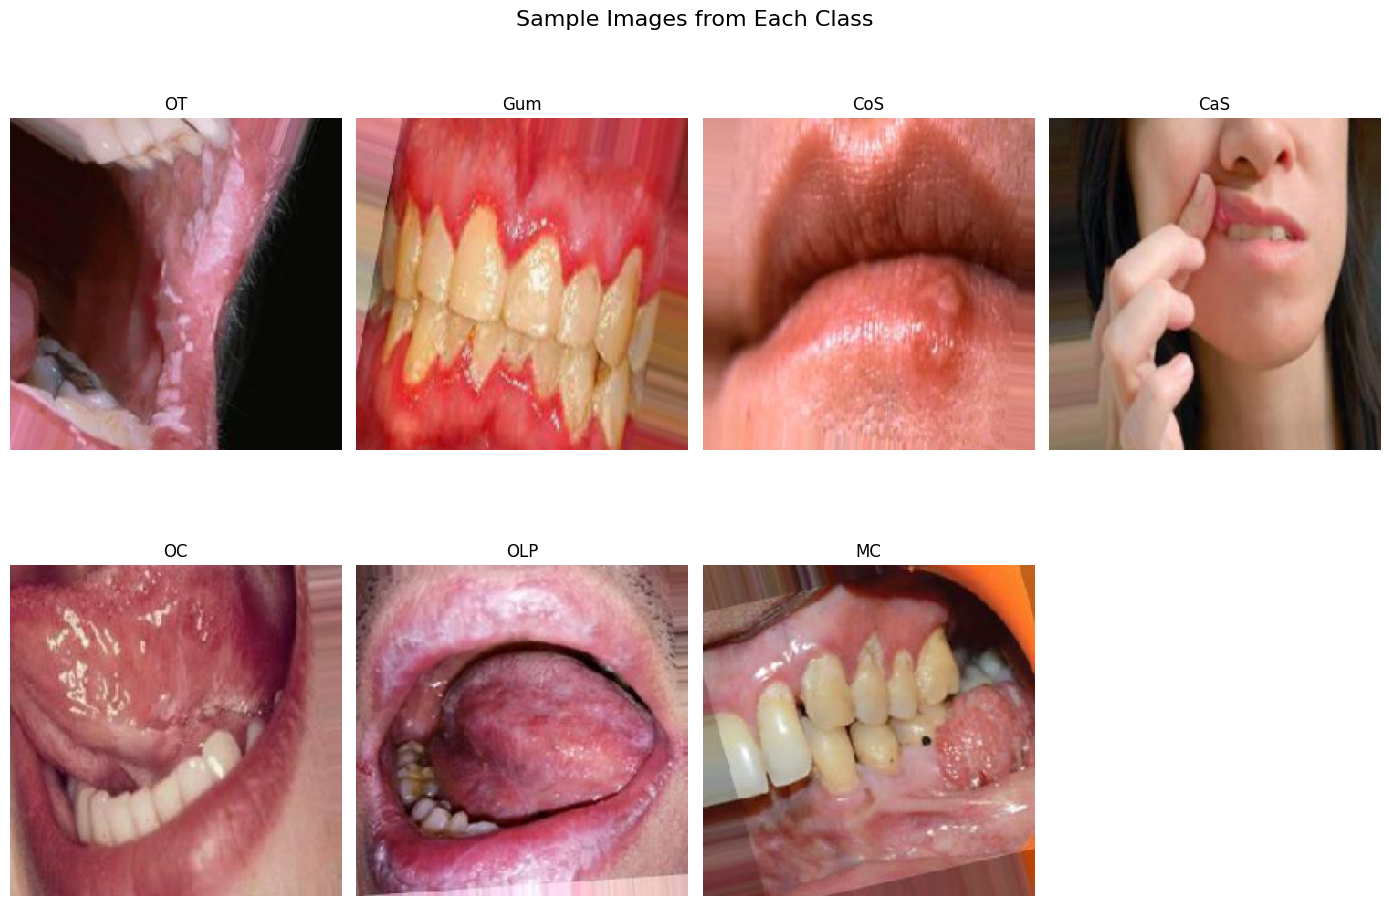

In [ ]:
plt.figure(figsize=(14, 10))
for idx, class_name in enumerate(class_names[:7]):
    class_folder = os.path.join(train_dir, class_name)
    image_path = os.path.join(class_folder, random.choice(os.listdir(class_folder)))
    img = load_img(image_path, target_size=(224, 224))

    plt.subplot(2, 4, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
train_datagen= ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



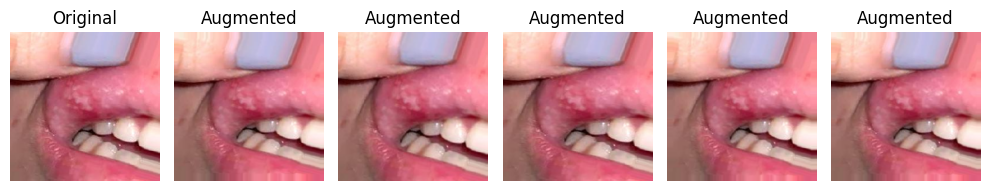

In [ ]:
sample_class = class_names[3]
sample_image_path = os.path.join(train_dir, sample_class, os.listdir(os.path.join(train_dir, sample_class))[0])

# Load image and convert it to array
img = load_img(sample_image_path, target_size=(224, 224))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)  # Reshape to match input shape expected by flow()

# Plot original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

# Generate and plot 5 augmented images
i = 2
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(1, 6, i)
    aug_img = array_to_img(batch[0])
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis('off')
    i += 1
    if i > 6:
        break

plt.tight_layout()
plt.show()

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [75]:
model= tf.keras.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001), input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # 7 classes
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)              │ (None, 222, 222, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 222, 222, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 111, 111, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 109, 109, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 54, 54, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 54, 54, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 52, 52, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 10, 10, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160,135 (4.43 MB)

 Trainable params: 1,158,599 (4.42 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
early_stop= EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5',monitor='val_accuracy',save_best_only=True,mode='max')

In [76]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 573ms/step - accuracy: 0.1837 - loss: 2.1105 - val_accuracy: 0.1907 - val_loss: 1.9275
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 519ms/step - accuracy: 0.2554 - loss: 1.8485 - val_accuracy: 0.1751 - val_loss: 2.1173
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 520ms/step - accuracy: 0.3127 - loss: 1.7286 - val_accuracy: 0.1751 - val_loss: 2.4068
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 524ms/step - accuracy: 0.3456 - loss: 1.6619 - val_accuracy: 0.2062 - val_loss: 2.0306
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 512ms/step - accuracy: 0.3848 - loss: 1.5650 - val_accuracy: 0.3045 - val_loss: 1.7488
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.4312 - loss: 1.4833

97/97 ━━━━━━━━━━━━━━━━━━━━ 84s 532ms/step - accuracy: 0.4312 - loss: 1.4832 - val_accuracy: 0.4105 - val_loss: 1.5276
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 515ms/step - accuracy: 0.4652 - loss: 1.3875 - val_accuracy: 0.3755 - val_loss: 1.7464
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 511ms/step - accuracy: 0.5017 - loss: 1.3371 - val_accuracy: 0.4056 - val_loss: 1.6292
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 528ms/step - accuracy: 0.5409 - loss: 1.2217 - val_accuracy: 0.2947 - val_loss: 2.3528
Epoch 10/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 516ms/step - accuracy: 0.5679 - loss: 1.1642 - val_accuracy: 0.4037 - val_loss: 1.8067
Epoch 11/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 517ms/step - accuracy: 0.5994 - loss: 1.0806 - val_accuracy: 0.3473 - val_loss: 2.2415
Epoch 12/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.6317 - loss: 1.0152

97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 518ms/step - accuracy: 0.6316 - loss: 1.0152 - val_accuracy: 0.5039 - val_loss: 1.3643
Epoch 13/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 505ms/step - accuracy: 0.6464 - loss: 0.9412 - val_accuracy: 0.3842 - val_loss: 1.9006
Epoch 14/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.6722 - loss: 0.8947

97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 517ms/step - accuracy: 0.6722 - loss: 0.8948 - val_accuracy: 0.6187 - val_loss: 1.0423
Epoch 15/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 527ms/step - accuracy: 0.7256 - loss: 0.7730 - val_accuracy: 0.5700 - val_loss: 1.1958
Epoch 16/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.7432 - loss: 0.7560

97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 507ms/step - accuracy: 0.7432 - loss: 0.7560 - val_accuracy: 0.6313 - val_loss: 1.0139
Epoch 17/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 516ms/step - accuracy: 0.7659 - loss: 0.6715 - val_accuracy: 0.4767 - val_loss: 1.7585
Epoch 18/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 521ms/step - accuracy: 0.7582 - loss: 0.6686 - val_accuracy: 0.5671 - val_loss: 1.4631
Epoch 19/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 512ms/step - accuracy: 0.7899 - loss: 0.5957 - val_accuracy: 0.5895 - val_loss: 1.2590
Epoch 20/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8183 - loss: 0.5357

97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 529ms/step - accuracy: 0.8183 - loss: 0.5358 - val_accuracy: 0.6566 - val_loss: 1.2202
Epoch 21/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8320 - loss: 0.5180

97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 530ms/step - accuracy: 0.8320 - loss: 0.5179 - val_accuracy: 0.6800 - val_loss: 1.0226
Epoch 22/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 496ms/step - accuracy: 0.8610 - loss: 0.4184 - val_accuracy: 0.6615 - val_loss: 1.1768
Epoch 23/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 513ms/step - accuracy: 0.8840 - loss: 0.3396 - val_accuracy: 0.6663 - val_loss: 1.0788
Epoch 24/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 494ms/step - accuracy: 0.8787 - loss: 0.3791 - val_accuracy: 0.5331 - val_loss: 1.9162
Epoch 25/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 502ms/step - accuracy: 0.8863 - loss: 0.3491 - val_accuracy: 0.5603 - val_loss: 1.7696
Epoch 26/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 520ms/step - accuracy: 0.8905 - loss: 0.3361 - val_accuracy: 0.6012 - val_loss: 1.5372


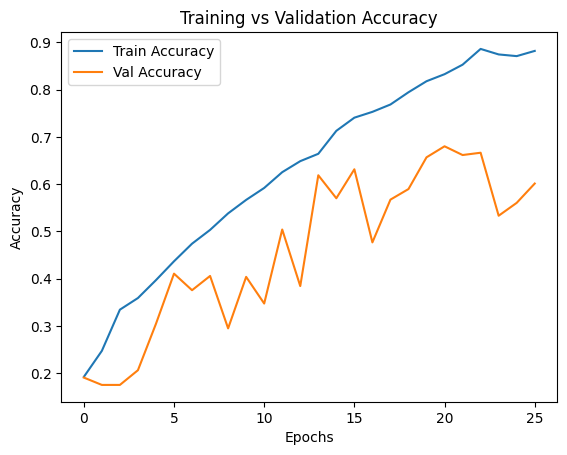

In [77]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

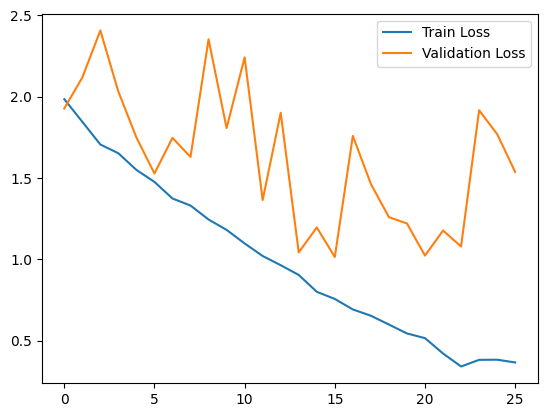

In [85]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

In [78]:
loss, acc = model.evaluate(test_generator)
print(f"Test accuracy: {acc:.2f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.5803 - loss: 1.0994 
Test accuracy: 0.62


In [80]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step 


In [83]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         CaS       0.18      0.26      0.21       160
         CoS       0.14      0.09      0.11       149
         Gum       0.12      0.16      0.14       120
          MC       0.18      0.20      0.19       180
          OC       0.15      0.10      0.12       108
         OLP       0.19      0.15      0.17       180
          OT       0.12      0.11      0.11       131

    accuracy                           0.16      1028
   macro avg       0.15      0.15      0.15      1028
weighted avg       0.16      0.16      0.15      1028



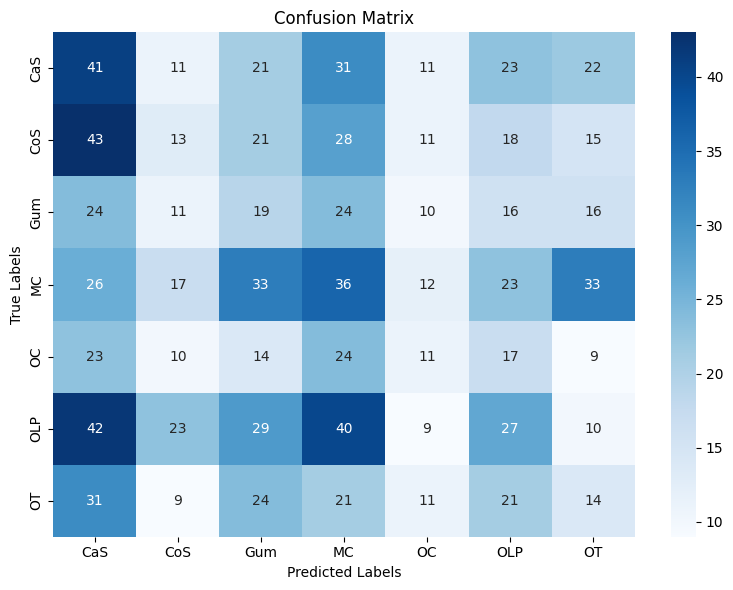

In [90]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()